# Time Series Forecasting: ARIMA vs SARIMA vs LSTM

This notebook compares **classical statistical models** (ARIMA, SARIMA) with a **deep learning model** (LSTM) for stock price forecasting.

## Dataset Strategy
We use two contrasting assets:
- **BND (Vanguard Total Bond Market ETF)**: Stable, low volatility — good for testing if ARIMA can capture steady trends.
- **TSLA (Tesla)**: Highly volatile, non-linear patterns — a stress test for LSTM.

## What You'll Learn
1. How to check for **stationarity** (ADF test)
2. How **ARIMA/SARIMA** automatically select parameters
3. How **LSTM** handles sequential data with proper scaling
4. How to **fairly compare** models using the same train/test split

---
## 1. Setup & Imports

We import all necessary libraries. Run `pip install yfinance pmdarima tensorflow` if needed.

In [1]:
# === Core libraries ===
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

# === Data fetching ===
import yfinance as yf

# === Statistical tests & ARIMA ===
from statsmodels.tsa.stattools import adfuller
import pmdarima as pm

# === ML utilities ===
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error

# === Deep learning ===
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

# === Reproducibility ===
np.random.seed(42)
tf.random.set_seed(42)

# === Plot style ===
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 5)

print("Setup complete!")

Setup complete!


---
## 2. Configuration

Central place to adjust all parameters. Change these to experiment with different settings.

In [2]:
# === Date range for historical data ===
START = "2015-01-01"
END = "2025-01-15"

# === Tickers to compare ===
TICKERS = ["BND", "TSLA"]  # Stable vs Volatile

# === Test set size (last N trading days) ===
TEST_DAYS = 30

# === LSTM hyperparameters ===
LSTM_LOOKBACK = 60  # Number of past days to use for prediction
EPOCHS = 30
BATCH_SIZE = 32

print(f"Config: {START} to {END}, Test={TEST_DAYS} days, LSTM lookback={LSTM_LOOKBACK}")

Config: 2015-01-01 to 2025-01-15, Test=30 days, LSTM lookback=60


---
## 3. Helper Functions

Reusable functions to keep the notebook clean and readable.

In [3]:
def fetch_price(ticker, start=START, end=END):
    """
    Download adjusted closing price from Yahoo Finance.
    Returns a clean 1D pandas Series with DatetimeIndex.
    
    Note: yfinance can return MultiIndex columns like ('Adj Close', 'TSLA').
    We handle this by selecting the column and squeezing to 1D.
    """
    df = yf.download(ticker, start=start, end=end, auto_adjust=False, progress=False)
    
    # Handle MultiIndex columns (yfinance returns this format)
    if isinstance(df.columns, pd.MultiIndex):
        # Try to get Adj Close, fall back to Close
        if "Adj Close" in df.columns.get_level_values(0):
            s = df["Adj Close"][ticker]
        else:
            s = df["Close"][ticker]
    else:
        col = "Adj Close" if "Adj Close" in df.columns else "Close"
        s = df[col]
    
    # Ensure it's a Series (not DataFrame)
    if isinstance(s, pd.DataFrame):
        s = s.squeeze()
    
    s = s.dropna().sort_index()
    s.name = "price"
    return s


def adf_test(series, name=""):
    """
    Augmented Dickey-Fuller test for stationarity.
    - p-value < 0.05 => stationary (reject null hypothesis of unit root)
    - p-value >= 0.05 => non-stationary
    """
    # Ensure we have a 1D array
    vals = np.asarray(series).ravel()
    vals = vals[~np.isnan(vals)]
    result = adfuller(vals, autolag="AIC")
    stat, pvalue = result[0], result[1]
    status = "Stationary" if pvalue < 0.05 else "Non-stationary"
    print(f"{name:20} | ADF Stat: {stat:8.4f} | p-value: {pvalue:.4f} | {status}")
    return pvalue


def train_test_split(series, test_days=TEST_DAYS):
    """
    Split time series into train and test sets.
    Test set = last `test_days` observations.
    """
    train = series.iloc[:-test_days].copy()
    test = series.iloc[-test_days:].copy()
    return train, test


def calc_metrics(actual, predicted):
    """
    Calculate MAE and RMSE.
    
    Handles any input type: Series, DataFrame, ndarray, list.
    Uses positional alignment (not index alignment).
    Drops NaN values before computing.
    """
    # Convert to flat numpy arrays
    if hasattr(actual, 'values'):
        actual = actual.values
    if hasattr(predicted, 'values'):
        predicted = predicted.values
    
    actual = np.asarray(actual).flatten()
    predicted = np.asarray(predicted).flatten()
    
    # Ensure same length
    min_len = min(len(actual), len(predicted))
    actual = actual[:min_len]
    predicted = predicted[:min_len]
    
    # Remove NaN pairs
    mask = ~(np.isnan(actual) | np.isnan(predicted))
    actual = actual[mask]
    predicted = predicted[mask]
    
    if len(actual) == 0:
        raise ValueError("No valid samples after removing NaNs")
    
    mae = np.mean(np.abs(actual - predicted))
    rmse = np.sqrt(np.mean((actual - predicted) ** 2))
    return mae, rmse


def create_sequences(data, lookback):
    """
    Convert time series to supervised learning format for LSTM.
    X[i] = data[i-lookback : i]
    y[i] = data[i]
    """
    X, y = [], []
    for i in range(lookback, len(data)):
        X.append(data[i - lookback:i])
        y.append(data[i])
    return np.array(X), np.array(y)


print("Helper functions defined!")

Helper functions defined!


---
## 4. Data Acquisition

Download historical daily prices for both tickers using `yfinance`.

In [4]:
# Download data for both tickers
data = {}
for ticker in TICKERS:
    data[ticker] = fetch_price(ticker)
    print(f"{ticker}: {len(data[ticker])} days from {data[ticker].index.min().date()} to {data[ticker].index.max().date()}")

BND: 2524 days from 2015-01-02 to 2025-01-14
TSLA: 2524 days from 2015-01-02 to 2025-01-14


### Output Explanation (Data Download)

You should see something like:
- `BND: 2524 days from 2015-01-02 to 2025-01-14`
- `TSLA: 2524 days from 2015-01-02 to 2025-01-14`

How to interpret:
- **Number of rows**: roughly `~252 trading days/year * 10 years ≈ 2500`.
- **Same date range for both tickers**: that’s important for a fair comparison.
- If a ticker shows fewer rows, it usually means:
  - missing history
  - delisted symbol
  - temporary download issues

What we do next:
- We treat the **last 30 trading days** as the test period for forecasting.

---
## 5. Exploratory Data Analysis (EDA)

### 5.1 Price Visualization
Let's visualize the price history to see the difference in volatility.

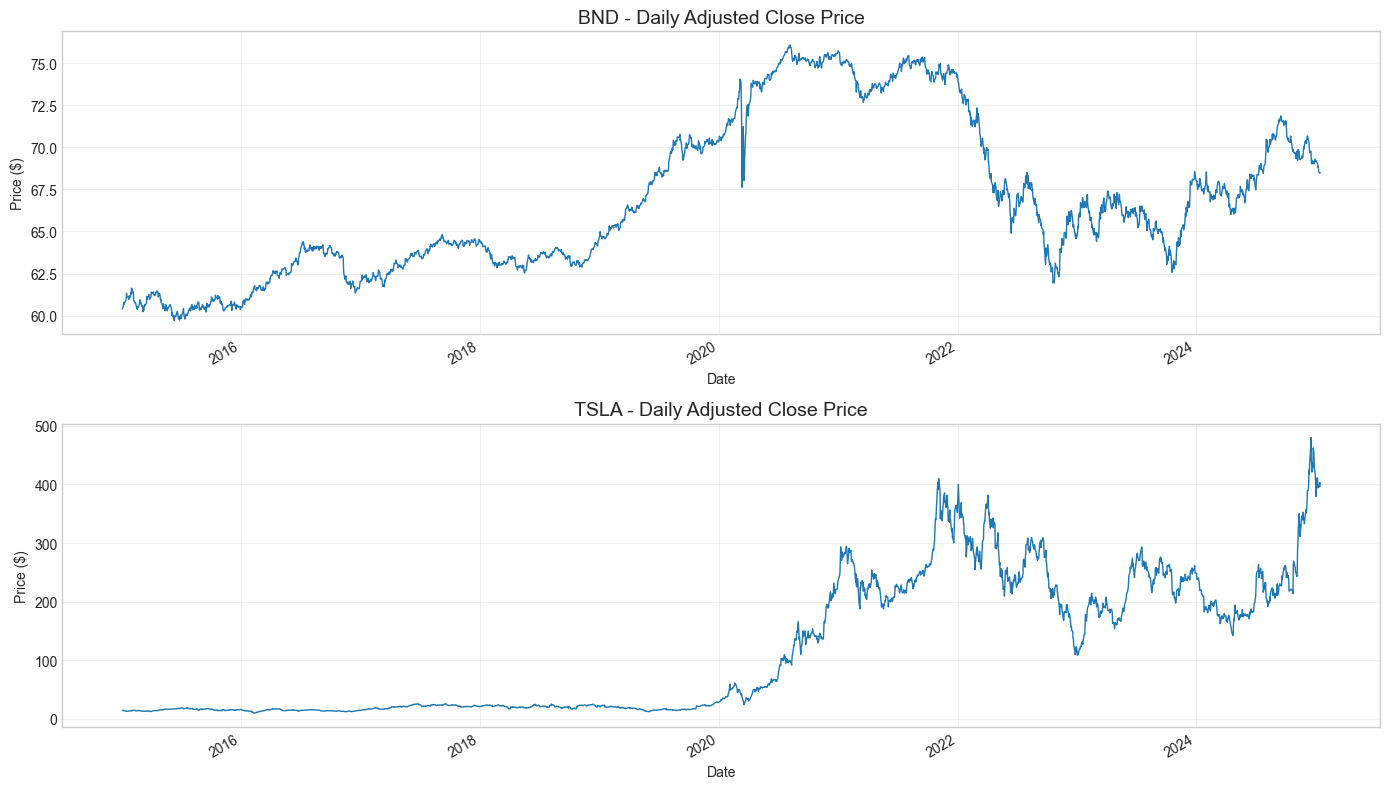

In [5]:
fig, axes = plt.subplots(2, 1, figsize=(14, 8))

for ax, ticker in zip(axes, TICKERS):
    data[ticker].plot(ax=ax, linewidth=1)
    ax.set_title(f"{ticker} - Daily Adjusted Close Price", fontsize=14)
    ax.set_xlabel("Date")
    ax.set_ylabel("Price ($)")
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### Output Explanation
- **BND**: Relatively flat, oscillates in a narrow range (~$70-$90). This is typical of bond ETFs — stable and mean-reverting.
- **TSLA**: Dramatic swings, exponential growth periods, and sharp corrections. This volatility makes it harder for linear models to predict.

### 5.2 Rolling Volatility Comparison

We calculate **30-day rolling standard deviation of daily returns** to quantify volatility.

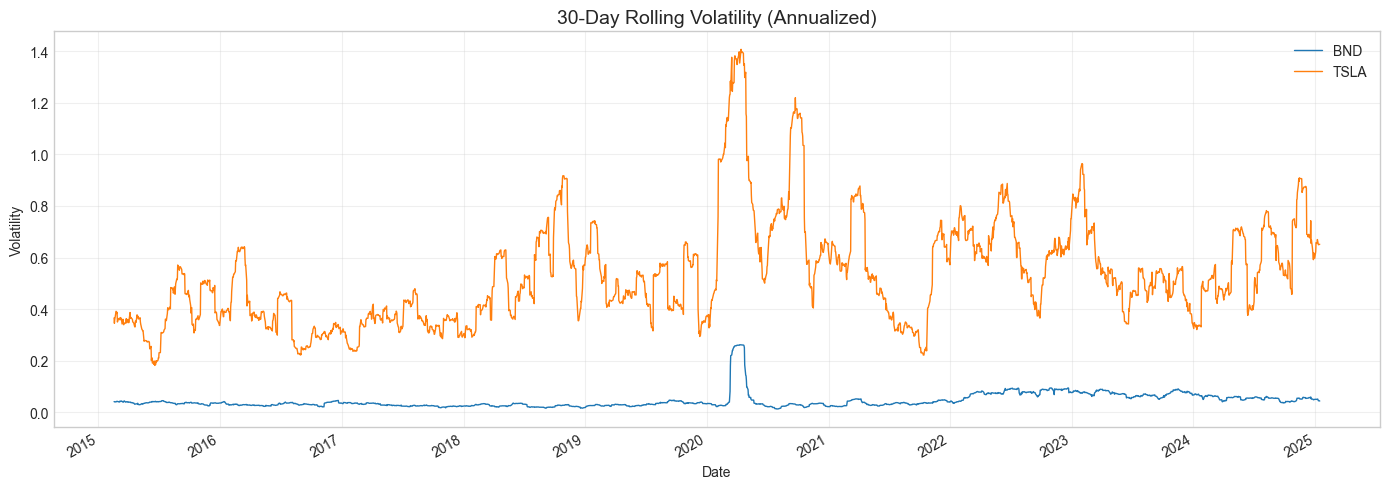

In [6]:
fig, ax = plt.subplots(figsize=(14, 5))

for ticker in TICKERS:
    # Calculate daily log returns
    returns = np.log(data[ticker]).diff()
    # 30-day rolling standard deviation
    rolling_vol = returns.rolling(window=30).std() * np.sqrt(252)  # Annualized
    rolling_vol.plot(ax=ax, label=ticker, linewidth=1)

ax.set_title("30-Day Rolling Volatility (Annualized)", fontsize=14)
ax.set_xlabel("Date")
ax.set_ylabel("Volatility")
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

### Output Explanation
- **BND volatility**: Stays low (typically < 10%), with occasional spikes during market stress (e.g., 2020 COVID crash).
- **TSLA volatility**: Much higher (often 50-100%+), with frequent large spikes. This confirms TSLA is our "stress test" for models.

---
## 6. Stationarity Analysis

### Why Stationarity Matters
- **ARIMA assumes stationarity** (or can achieve it via differencing).
- A **stationary** series has constant mean and variance over time.
- Stock **prices** are typically non-stationary (they trend up/down).
- Stock **returns** (price changes) are usually stationary.

### Augmented Dickey-Fuller (ADF) Test
- **Null hypothesis**: The series has a unit root (non-stationary).
- **p-value < 0.05**: Reject null → series is stationary.
- **p-value ≥ 0.05**: Fail to reject → series is non-stationary.

In [7]:
print("=" * 70)
print("STATIONARITY TEST RESULTS")
print("=" * 70)

for ticker in TICKERS:
    print(f"\n--- {ticker} ---")
    price = data[ticker]
    returns = np.log(price).diff().dropna()
    
    adf_test(price, f"{ticker} Price")
    adf_test(returns, f"{ticker} Log Returns")

STATIONARITY TEST RESULTS

--- BND ---
BND Price            | ADF Stat:  -1.5323 | p-value: 0.5175 | Non-stationary
BND Log Returns      | ADF Stat:  -9.8703 | p-value: 0.0000 | Stationary

--- TSLA ---
TSLA Price           | ADF Stat:  -0.5970 | p-value: 0.8717 | Non-stationary
TSLA Log Returns     | ADF Stat: -34.4491 | p-value: 0.0000 | Stationary


### Output Explanation (Stationarity / ADF)

You’ll see 2 lines per ticker:
- `Ticker Price | p-value = ...`
- `Ticker Log Returns | p-value = ...`

How to interpret ADF:
- **Null hypothesis**: the series is **non-stationary** (has a unit root).
- If **p-value < 0.05**: reject null ⇒ **stationary**.
- If **p-value ≥ 0.05**: fail to reject ⇒ **non-stationary**.

What you should expect (and why it matters):
- **Prices are usually non-stationary** (p-value often > 0.05) because they trend and change regime.
- **Returns are usually stationary** (p-value often < 0.05) because they fluctuate around ~0.

Connection to models:
- **ARIMA/SARIMA** assume stationarity (or achieve it via differencing).
  - That’s why you often see `d=1` in ARIMA orders: the model needed one differencing step.
- **LSTM** does not require stationarity, but it needs scaling and enough data.

---
## 7. Train/Test Split

We use the **last 30 trading days** as our test set. All models will predict this same period for fair comparison.

In [8]:
# Store train/test splits for each ticker
splits = {}
for ticker in TICKERS:
    train, test = train_test_split(data[ticker])
    splits[ticker] = {"train": train, "test": test}
    print(f"{ticker}: Train={len(train)} days, Test={len(test)} days")
    print(f"        Test period: {test.index.min().date()} to {test.index.max().date()}")

BND: Train=2494 days, Test=30 days
        Test period: 2024-11-29 to 2025-01-14
TSLA: Train=2494 days, Test=30 days
        Test period: 2024-11-29 to 2025-01-14


### Output Explanation
- **Train set**: All data except the last 30 days — used to fit models.
- **Test set**: Last 30 trading days — used to evaluate predictions.
- This ensures a **fair comparison** since all models predict the exact same dates.

---
## 8. ARIMA Model

### What is ARIMA?
- **AR (AutoRegressive)**: Uses past values to predict future values.
- **I (Integrated)**: Differencing to make the series stationary.
- **MA (Moving Average)**: Uses past forecast errors.

### Parameters (p, d, q)
- **p**: Number of lag observations (AR terms)
- **d**: Degree of differencing
- **q**: Size of moving average window

We use `auto_arima` to automatically find the best parameters.

In [9]:
# Store results
results = []  # List of dicts for metrics table
predictions = {ticker: {} for ticker in TICKERS}  # Store predictions for plotting

print("=" * 70)
print("ARIMA MODEL FITTING")
print("=" * 70)

for ticker in TICKERS:
    print(f"\n--- {ticker} ---")
    train = splits[ticker]["train"].astype(float)
    test = splits[ticker]["test"].astype(float)

    # Fit ARIMA with automatic parameter selection
    arima_model = pm.auto_arima(
        train,
        seasonal=False,      # No seasonal component
        stepwise=True,       # Faster search
        suppress_warnings=True,
        error_action="ignore"
    )

    # Print selected order
    print(f"Best ARIMA order: {arima_model.order}")
    print(f"AIC: {arima_model.aic():.2f}")

    # Forecast (ensure a clean float array)
    arima_pred = np.asarray(arima_model.predict(n_periods=TEST_DAYS), dtype=float).reshape(-1)

    # If the model produced NaNs, fall back to a simple baseline (last value carry-forward)
    if np.isnan(arima_pred).any():
        last_value = float(train.iloc[-1])
        arima_pred = np.where(np.isnan(arima_pred), last_value, arima_pred)

    arima_pred = pd.Series(arima_pred, index=test.index, name="ARIMA")

    # Calculate metrics
    mae, rmse = calc_metrics(test, arima_pred)
    print(f"MAE: {mae:.4f}, RMSE: {rmse:.4f}")

    # Store results
    predictions[ticker]["ARIMA"] = arima_pred
    results.append({"Ticker": ticker, "Model": "ARIMA", "Order": str(arima_model.order), "MAE": mae, "RMSE": rmse})

ARIMA MODEL FITTING

--- BND ---
Best ARIMA order: (2, 1, 2)
AIC: -234.32
MAE: 0.7694, RMSE: 0.8943

--- TSLA ---


/Users/macbookpro/Documents/Time_series_demo/.venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


Best ARIMA order: (2, 1, 2)
AIC: 16046.70
MAE: 74.8261, RMSE: 81.9819


/Users/macbookpro/Documents/Time_series_demo/.venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


### Output Explanation (ARIMA)

You’ll see output like:
- `Best ARIMA order: (p, d, q)`
- `AIC: ...`
- `MAE: ... , RMSE: ...`

How to interpret:
- **(p, d, q)**:
  - `p`: how many lagged values the model uses.
  - `d`: how many differencing steps were needed to make the series stationary.
  - `q`: how many lagged forecast errors are used.
- **AIC** (Akaike Information Criterion):
  - Used internally to select a model.
  - **Lower AIC is better** (but only comparable within the same ticker/model family).

Why you might see a warning about the index:
- Sometimes statsmodels prints a message like:
  - `No supported index is available. Prediction results will be given with an integer index...`
- This is about the forecasting index metadata, not about the numeric forecast quality.

How to interpret MAE/RMSE:
- **MAE**: average absolute error in dollars.
- **RMSE**: like MAE but penalizes large mistakes more.
- For the same ticker: **lower is better**.

Practical expectations:
- **BND (stable)** often yields smaller errors and smoother forecasts.
- **TSLA (volatile)** often yields larger errors because the future is harder to extrapolate from a linear model.

Note on robustness:
- If ARIMA produces NaNs (rare but possible), this notebook replaces them with a simple baseline (last observed train value) so the comparison can continue.

---
## 9. SARIMA Model

### What is SARIMA?
SARIMA = ARIMA + **Seasonal** component.

### Seasonal Parameters (P, D, Q, m)
- **P, D, Q**: Seasonal versions of p, d, q
- **m**: Seasonal period (we use m=5 for the 5-day trading week)

This can capture weekly patterns in trading data.

In [10]:
print("=" * 70)
print("SARIMA MODEL FITTING (m=5 for trading week)")
print("=" * 70)

for ticker in TICKERS:
    print(f"\n--- {ticker} ---")
    train = splits[ticker]["train"].astype(float)
    test = splits[ticker]["test"].astype(float)

    # Fit SARIMA with seasonal component
    sarima_model = pm.auto_arima(
        train,
        seasonal=True,       # Enable seasonal component
        m=5,                 # 5-day trading week
        stepwise=True,
        suppress_warnings=True,
        error_action="ignore"
    )

    # Print selected orders
    print(f"Best SARIMA order: {sarima_model.order}")
    print(f"Seasonal order: {sarima_model.seasonal_order}")
    print(f"AIC: {sarima_model.aic():.2f}")

    # Forecast (ensure a clean float array)
    sarima_pred = np.asarray(sarima_model.predict(n_periods=TEST_DAYS), dtype=float).reshape(-1)

    # If the model produced NaNs, fall back to a simple baseline (last value carry-forward)
    if np.isnan(sarima_pred).any():
        last_value = float(train.iloc[-1])
        sarima_pred = np.where(np.isnan(sarima_pred), last_value, sarima_pred)

    sarima_pred = pd.Series(sarima_pred, index=test.index, name="SARIMA")

    # Calculate metrics
    mae, rmse = calc_metrics(test, sarima_pred)
    print(f"MAE: {mae:.4f}, RMSE: {rmse:.4f}")

    # Store results
    predictions[ticker]["SARIMA"] = sarima_pred
    results.append({"Ticker": ticker, "Model": "SARIMA", "Order": f"{sarima_model.order}x{sarima_model.seasonal_order}", "MAE": mae, "RMSE": rmse})

SARIMA MODEL FITTING (m=5 for trading week)

--- BND ---
Best SARIMA order: (2, 1, 2)
Seasonal order: (0, 0, 0, 5)
AIC: -234.32
MAE: 0.7694, RMSE: 0.8943

--- TSLA ---


/Users/macbookpro/Documents/Time_series_demo/.venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


Best SARIMA order: (0, 1, 0)
Seasonal order: (1, 0, 1, 5)
AIC: 16055.87
MAE: 82.5660, RMSE: 89.6023


/Users/macbookpro/Documents/Time_series_demo/.venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


### Output Explanation (SARIMA)

You’ll see output like:
- `Best SARIMA order: (p, d, q)`
- `Seasonal order: (P, D, Q, m)`
- `AIC: ...`
- `MAE: ... , RMSE: ...`

How to interpret the seasonal part:
- `m=5` means the model is allowed to learn a **weekly (5 trading days)** cycle.
- `(P, D, Q)` are the seasonal equivalents of `(p, d, q)`.

What it means if seasonal order is mostly zeros:
- If you see something like `(0, 0, 0, 5)`, SARIMA didn’t find strong weekly seasonality.
- That’s common for stock prices.

How to compare SARIMA vs ARIMA:
- If SARIMA RMSE is **lower** than ARIMA for the same ticker, the seasonal structure helped.
- If it’s about the same (or worse), ARIMA is simpler and usually preferred.

Robustness note:
- As with ARIMA, if SARIMA produces NaNs, we replace them with the last observed train value so metrics can be computed.

---
## 10. LSTM Model

### What is LSTM?
- **Long Short-Term Memory**: A type of recurrent neural network (RNN).
- Can learn **complex, non-linear patterns** in sequential data.
- Uses "memory cells" to remember long-term dependencies.

### Architecture & Hyperparameters (what you control)
LSTMs require more design choices than ARIMA/SARIMA. In this notebook we choose:
- **Number of layers**: 2 LSTM layers (a common baseline)
- **Units (neurons)**: 64 then 32 (capacity to learn patterns)
- **Dropout**: 0.2 after each LSTM layer (reduces overfitting)
- **Optimizer**: Adam (robust default)
- **Loss**: MSE (standard regression loss)
- **Training**: `EPOCHS`, `BATCH_SIZE`, plus **EarlyStopping** to stop when validation loss stops improving

### Key Considerations
1. **Scaling**: Neural networks work best with normalized data (0-1 range).
2. **Lookback window**: How many past days to use for prediction.
3. **Leakage prevention**: Fit scaler on train data only!

### When to use LSTM
- Use LSTM when the time series has **complex, non-linear patterns** that traditional statistical models struggle with.
- LSTMs typically benefit from **more data**, but they are:
  - more **computationally intensive**
  - less **interpretable** than ARIMA/SARIMA

In [11]:
def build_lstm_model(lookback):
    """
    Build a simple LSTM model for time series forecasting.
    Architecture:
    - LSTM(64) with return_sequences for stacking
    - Dropout(0.2) to prevent overfitting
    - LSTM(32) final recurrent layer
    - Dropout(0.2)
    - Dense(1) output layer
    """
    model = Sequential([
        LSTM(64, return_sequences=True, input_shape=(lookback, 1)),
        Dropout(0.2),
        LSTM(32, return_sequences=False),
        Dropout(0.2),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')
    return model


def train_lstm(ticker, lookback=LSTM_LOOKBACK):
    """
    Train LSTM model for a given ticker.
    Returns predictions aligned to test index.
    """
    train = splits[ticker]["train"]
    test = splits[ticker]["test"]
    
    # === CRITICAL: Fit scaler on TRAIN only to prevent data leakage ===
    scaler = MinMaxScaler(feature_range=(0, 1))
    train_scaled = scaler.fit_transform(train.values.reshape(-1, 1)).ravel()
    
    # For prediction, we need lookback days before each test point
    # So we need to include some train data in our sequence creation
    full_series = pd.concat([train, test])
    full_scaled = scaler.transform(full_series.values.reshape(-1, 1)).ravel()
    
    # Create sequences from full scaled data
    X_all, y_all = create_sequences(full_scaled, lookback)
    
    # The y values correspond to indices [lookback, lookback+1, ..., len-1]
    # Map these back to dates
    y_dates = full_series.index[lookback:]
    
    # Split: train sequences have y_date in train.index
    train_mask = y_dates.isin(train.index)
    test_mask = y_dates.isin(test.index)
    
    X_train = X_all[train_mask][..., np.newaxis]  # Add feature dimension
    y_train = y_all[train_mask]
    X_test = X_all[test_mask][..., np.newaxis]
    
    # Build and train model
    model = build_lstm_model(lookback)
    
    early_stop = EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True
    )
    
    history = model.fit(
        X_train, y_train,
        validation_split=0.2,
        epochs=EPOCHS,
        batch_size=BATCH_SIZE,
        callbacks=[early_stop],
        verbose=0
    )
    
    # Predict and inverse transform
    pred_scaled = model.predict(X_test, verbose=0).ravel()
    pred = scaler.inverse_transform(pred_scaled.reshape(-1, 1)).ravel()
    
    # Align to test dates
    pred_series = pd.Series(pred, index=test.index, name="LSTM")
    
    return pred_series, history

In [12]:
print("=" * 70)
print("LSTM MODEL TRAINING")
print("=" * 70)

for ticker in TICKERS:
    print(f"\n--- {ticker} ---")
    print(f"Training LSTM with lookback={LSTM_LOOKBACK}...")
    
    lstm_pred, history = train_lstm(ticker)
    
    # Get actual test values
    test = splits[ticker]["test"]
    
    # Calculate metrics
    mae, rmse = calc_metrics(test, lstm_pred)
    print(f"Training stopped at epoch {len(history.history['loss'])}")
    print(f"MAE: {mae:.4f}, RMSE: {rmse:.4f}")
    
    # Store results
    predictions[ticker]["LSTM"] = lstm_pred
    results.append({"Ticker": ticker, "Model": "LSTM", "Order": f"lookback={LSTM_LOOKBACK}", "MAE": mae, "RMSE": rmse})

LSTM MODEL TRAINING

--- BND ---
Training LSTM with lookback=60...
Training stopped at epoch 30
MAE: 0.3772, RMSE: 0.4466

--- TSLA ---
Training LSTM with lookback=60...
Training stopped at epoch 30
MAE: 23.3816, RMSE: 27.6948


### Output Explanation (LSTM Training)

You’ll see something like:
- `Training stopped at epoch X`
- `MAE: ... , RMSE: ...`

How to interpret:
- **Training stopped at epoch X**:
  - We use **EarlyStopping** on validation loss.
  - If the model stops early, it means additional epochs were not improving generalization.

Why LSTM metrics can vary:
- LSTMs are optimized with stochastic methods; small differences can happen between runs.
- Seeds are set, but GPU/low-level ops can still introduce some variation.

How to judge if LSTM helped:
- Compare LSTM RMSE against ARIMA/SARIMA for the same ticker.
  - If LSTM is better on **TSLA**, that supports the idea that it captured non-linear patterns.
  - If LSTM is worse on **BND**, that’s normal: deep models can overfit stable/low-signal series.

Common failure mode (and what to do):
- If LSTM predictions look too smooth or laggy:
  - Increase `LSTM_LOOKBACK`
  - Increase units slightly (e.g., 64/32 → 128/64)
  - Train a bit longer (increase `EPOCHS`) but keep EarlyStopping enabled.

---
## 11. Results Comparison

### Metrics Summary Table
Let's compare all models side by side.

In [13]:
# Create results DataFrame
results_df = pd.DataFrame(results)

# Format for display
results_df["MAE"] = results_df["MAE"].round(4)
results_df["RMSE"] = results_df["RMSE"].round(4)

print("=" * 70)
print("MODEL COMPARISON - METRICS SUMMARY")
print("=" * 70)
print()
print(results_df.to_string(index=False))

MODEL COMPARISON - METRICS SUMMARY

Ticker  Model                  Order     MAE    RMSE
   BND  ARIMA              (2, 1, 2)  0.7694  0.8943
  TSLA  ARIMA              (2, 1, 2) 74.8261 81.9819
   BND SARIMA (2, 1, 2)x(0, 0, 0, 5)  0.7694  0.8943
  TSLA SARIMA (0, 1, 0)x(1, 0, 1, 5) 82.5660 89.6023
   BND   LSTM            lookback=60  0.3772  0.4466
  TSLA   LSTM            lookback=60 23.3816 27.6948


In [14]:
# Pivot table for easier comparison
print("\n" + "=" * 70)
print("RMSE BY TICKER AND MODEL")
print("=" * 70)

pivot = results_df.pivot(index="Ticker", columns="Model", values="RMSE")
print(pivot.round(4))

# Highlight best model per ticker
print("\n--- Best Model (Lowest RMSE) ---")
for ticker in TICKERS:
    best_model = pivot.loc[ticker].idxmin()
    best_rmse = pivot.loc[ticker].min()
    print(f"{ticker}: {best_model} (RMSE={best_rmse:.4f})")


RMSE BY TICKER AND MODEL
Model     ARIMA     LSTM   SARIMA
Ticker                           
BND      0.8943   0.4466   0.8943
TSLA    81.9819  27.6948  89.6023

--- Best Model (Lowest RMSE) ---
BND: LSTM (RMSE=0.4466)
TSLA: LSTM (RMSE=27.6948)


### Output Explanation (Metrics Summary)

You will see:
- A table with rows like `(Ticker, Model, MAE, RMSE)`
- A pivot table showing RMSE per ticker and model
- A “Best Model (Lowest RMSE)” summary

How to interpret:
- **Compare models within the same ticker**.
  - Don’t compare BND RMSE to TSLA RMSE directly — TSLA is simply a harder, higher-volatility series.
- **RMSE vs MAE**:
  - If RMSE is much larger than MAE, the model occasionally made **big mistakes**.

Typical expected outcome:
- **BND**:
  - ARIMA/SARIMA often do well because the series is relatively smooth.
- **TSLA**:
  - LSTM sometimes wins, but not always — volatile assets can be close to random walks.

Important note:
- Even if one model wins on RMSE, always look at the plot — a model can have a slightly better RMSE but still miss key turning points.

---
## 12. Forecast Visualization

Visual comparison of actual vs predicted prices for the test period.

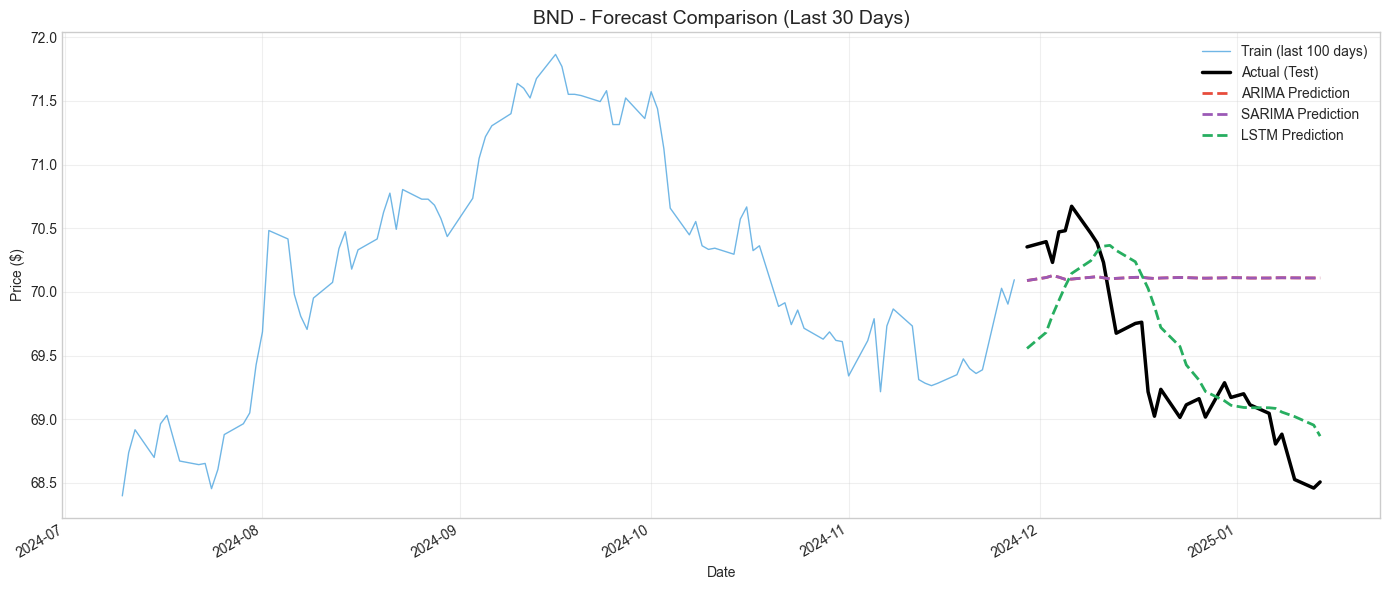

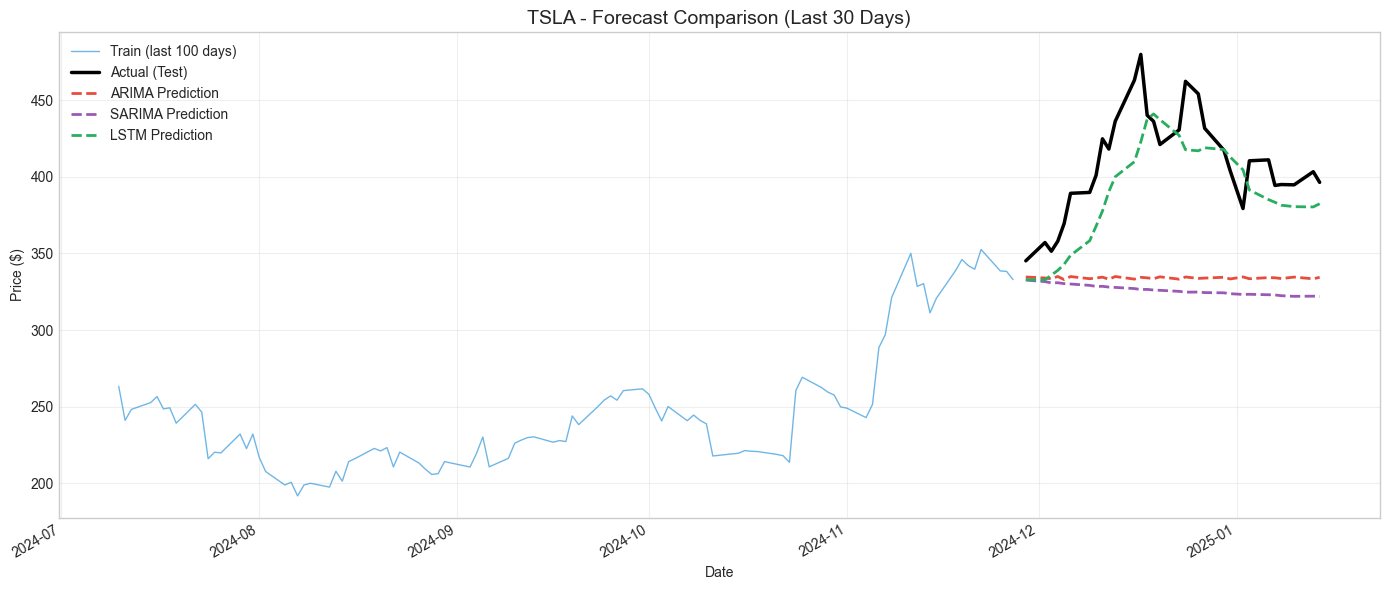

In [15]:
# Color scheme for models
colors = {"ARIMA": "#e74c3c", "SARIMA": "#9b59b6", "LSTM": "#27ae60"}

for ticker in TICKERS:
    fig, ax = plt.subplots(figsize=(14, 6))
    
    train = splits[ticker]["train"]
    test = splits[ticker]["test"]
    
    # Plot last 100 days of train for context
    train.tail(100).plot(ax=ax, label="Train (last 100 days)", color="#3498db", linewidth=1, alpha=0.7)
    
    # Plot actual test values
    test.plot(ax=ax, label="Actual (Test)", color="black", linewidth=2.5)
    
    # Plot predictions from each model
    for model_name, pred in predictions[ticker].items():
        pred.plot(ax=ax, label=f"{model_name} Prediction", color=colors[model_name], linewidth=2, linestyle="--")
    
    ax.set_title(f"{ticker} - Forecast Comparison (Last {TEST_DAYS} Days)", fontsize=14)
    ax.set_xlabel("Date")
    ax.set_ylabel("Price ($)")
    ax.legend(loc="best")
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

### Output Explanation (Forecast Plots)

What each line means:
- **Train (last 100 days)**: context leading up to the test period.
- **Actual (Test)** (black): the real observed prices for the last 30 trading days.
- **Model Prediction** (dashed): each model’s forecast over the same dates.

How to interpret visually:
- **Good forecast**: dashed line stays close to the black line.
- **Lagging forecast**: dashed line follows direction but reacts late (common for LSTM if lookback is too short/long).
- **Flat forecast**: ARIMA/SARIMA may look nearly flat on highly volatile series (a common outcome when the best linear forecast is close to “no change”).

What to conclude:
- If ARIMA/SARIMA are close on **BND**, it supports that classical models handle stable series well.
- If LSTM tracks the swings better on **TSLA**, it supports using deep learning for non-linear patterns.

Sanity checks:
- If predictions jump wildly outside the typical range, check:
  - scaling steps (LSTM)
  - whether the series used was `Adj Close` / `Close`
  - whether NaN handling was triggered (ARIMA/SARIMA fallback to last value).

---
## 13. Conclusions

### Key Takeaways

1. **Stationarity matters for ARIMA**:
   - Stock prices are non-stationary (they trend).
   - ARIMA handles this via differencing (the `d` parameter).
   - Returns are typically stationary.

2. **ARIMA/SARIMA strengths**:
   - Fast to train, interpretable parameters.
   - Work well on stable, mean-reverting data (like BND).
   - Seasonal component (SARIMA) helps if there's true seasonality.

3. **LSTM strengths**:
   - Can capture complex, non-linear patterns.
   - Better suited for volatile, unpredictable data (like TSLA).
   - Requires more data and careful preprocessing (scaling!).

4. **No free lunch**:
   - The "best" model depends on your data.
   - Always compare multiple approaches.
   - Past performance doesn't guarantee future results!

### Next Steps (Optional Extensions)
- Try **walk-forward validation** for more robust evaluation.
- Add **confidence intervals** for ARIMA forecasts.
- Experiment with **different LSTM architectures** (GRU, Transformer).
- Include **additional features** (volume, technical indicators).

In [16]:
print("\n" + "=" * 70)
print("NOTEBOOK COMPLETE!")
print("=" * 70)
print("\nSummary:")
print(f"- Analyzed {len(TICKERS)} tickers: {', '.join(TICKERS)}")
print(f"- Compared 3 models: ARIMA, SARIMA, LSTM")
print(f"- Test period: {TEST_DAYS} trading days")
print("\nCheck the metrics table and plots above to see which model performed best!")


NOTEBOOK COMPLETE!

Summary:
- Analyzed 2 tickers: BND, TSLA
- Compared 3 models: ARIMA, SARIMA, LSTM
- Test period: 30 trading days

Check the metrics table and plots above to see which model performed best!
